# Murder weapons

In [47]:
import numpy
import math
import matplotlib.pyplot as plt
%matplotlib inline

# Simulating a single cell experiment

1. `cell_no` – number of rows/cells.
2. `gene_no` – number of columns/genes.
3. We simulate count matrix by assuming it follows a hierarchical process: `poisson(lognormal(0, 0.1))`. This can be argued to make sense: poisson simulates the bead and lognormal simulates the true expression of a gene. Better models are possible (e.g. assuming different genes have different expression rates, etc.).
4. We simulate velocity to follow a normal distribution with mu=0 and sigma=1.

In [2]:
def create_cell(gene_no, function, constants):
    result = []
    for i in range(gene_no):
        result.append(function(*constants))
    return numpy.array(result).reshape(1, -1)

In [3]:
def create_experiment(cell_no, gene_no, function, constants):
    experiment = numpy.zeros(shape=(cell_no, gene_no))
    for i in range(cell_no):
        experiment[i, :] = create_cell(gene_no, function, constants)
    return experiment

In [4]:
spliced = create_experiment(10, 5, lambda mu, sigma: numpy.random.poisson(numpy.random.lognormal(mu, sigma)), [0, 0.1])

In [5]:
spliced

array([[3., 0., 1., 0., 1.],
       [0., 1., 0., 0., 1.],
       [1., 1., 1., 1., 0.],
       [0., 1., 1., 0., 2.],
       [0., 2., 2., 0., 3.],
       [2., 0., 1., 1., 2.],
       [1., 1., 0., 1., 2.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 1., 2.],
       [1., 1., 1., 0., 5.]])

In [6]:
velocity = create_experiment(10, 5, numpy.random.normal, [0, 1])

In [7]:
velocity

array([[ 1.05151268, -0.55523072,  0.29061882, -0.1593759 , -0.00610355],
       [ 0.4054233 ,  1.32432665, -1.73700818,  1.09682658, -2.09682831],
       [-1.85766264, -0.1108265 , -2.68564721,  1.26874672, -0.71221106],
       [-0.35501718, -1.03804739,  0.46941209, -0.04721858,  1.46723486],
       [ 1.34407834, -1.89079988, -1.01275049,  0.0318938 , -0.12724241],
       [ 0.97388816, -1.51737575, -0.0381651 ,  1.05337827,  0.68021291],
       [-1.58291447,  1.11226167, -0.14679966, -2.01815515,  0.36624999],
       [-0.65568299,  0.92119818,  1.15293346,  0.26607361,  0.817352  ],
       [-0.45746708, -0.4015977 ,  1.150407  , -0.64146672,  1.08375567],
       [-0.0533295 , -1.98975666,  1.29364153, -0.11064667, -0.98854568]])

In [8]:
velocity.shape

(10, 5)

In [9]:
assert velocity.shape == spliced.shape

That's how we can choose an example cell's velocity

In [10]:
example_velocity = velocity[-3, :]
example_velocity

array([-0.65568299,  0.92119818,  1.15293346,  0.26607361,  0.817352  ])

And an example cell

In [11]:
example_cell = spliced[-3, :]
example_cell

array([0., 0., 0., 1., 0.])

# The next bit is some rather easy linear algebra

We're just going to take a projection of velocity onto the position vector, and measure that. This will allow us to define and measure differentiation rate.

![velocity projection](https://trello-attachments.s3.amazonaws.com/5a982c9ba3afcf0a82b5b26c/5c84e116d5a3ed167f8ac28a/b4e329c442b2e809f7270ebf8ad8e07f/IMG_20190310_100347422.jpg)

In [12]:
def project(velocity, position):
    projection = numpy.dot(velocity, position)/numpy.linalg.norm(position)
    projection_vector = position/numpy.linalg.norm(position)*projection
    return projection, projection_vector

Exercise. Plot the following vectors and their respective projections on a sheet of paper

In [13]:
project([0, 1], [1, 0])

(0.0, array([0., 0.]))

In [14]:
project([0.1, 1], [1, 0])

(0.1, array([0.1, 0. ]))

In [15]:
project([0, 1], [1, 0.1])

(0.09950371902099893, array([0.0990099 , 0.00990099]))

In [16]:
project([1, 1], [2, 2])

(1.414213562373095, array([1., 1.]))

In [17]:
project([-1, -1], [2, 2])

(-1.414213562373095, array([-1., -1.]))

And that's how we can compute the projection for a single cell

In [18]:
project(velocity[-3, :], spliced[-3, :])

(0.2660736062384854,
 array([0.        , 0.        , 0.        , 0.26607361, 0.        ]))

We can now compute the ratio of average neutral velocity to average differentiation velocity. Let's call that "differentiation factor"

In [24]:
def compute_differentiation(spliced, velocity):
    differentiation_speed = []
    neutral_speed = []
    for cell_no in range(velocity.shape[0]):
        p = spliced[cell_no, :]
        v = velocity[cell_no, :]
        speed_away, velocity_away = project(v, p)
        neutral = numpy.linalg.norm(p - velocity_away)
        if not math.isnan(speed_away) and not math.isnan(neutral):
            differentiation_speed.append(speed_away)
            neutral_speed.append(neutral)
    differentiation_factor = sum(differentiation_speed)/sum(neutral_speed)
    return differentiation_factor, differentiation_speed, neutral_speed

In [25]:
compute_differentiation(spliced, velocity)

(-0.047351725209770525,
 [1.0369135864945325,
  -0.5462411630757292,
  -1.692694813273425,
  0.9658478551122979,
  -1.5010112641385764,
  1.367183971141273,
  -0.6638220210450826,
  0.2660736062384854,
  0.45905353652923775,
  -1.0757195924116887],
 [2.279711203860867,
  1.9604547254488243,
  3.692694813273425,
  1.48364188767088,
  5.6241168897562375,
  1.795093689027106,
  3.309573332109673,
  0.7339263937615146,
  1.9904362062539405,
  6.36722221454087])

# Centralising the experiment and computing the differentiation factor

Before we can use this method we have to determine the correct origin. I suggest just using the most average cell as the origin. This can be achieved by recentrilising the entire experiment to put the hypothetical "average cell" in the middle. We don't have to touch the velocity vectors, because the transformation doesn't affect them.

In [36]:
def centralise_experiment(spliced):
    average_cell = spliced.sum(0)/spliced.shape[0]
    for i in range(spliced.shape[0]):
        spliced[i, :] -= average_cell 

In [37]:
spliced

array([[3., 0., 1., 0., 1.],
       [0., 1., 0., 0., 1.],
       [1., 1., 1., 1., 0.],
       [0., 1., 1., 0., 2.],
       [0., 2., 2., 0., 3.],
       [2., 0., 1., 1., 2.],
       [1., 1., 0., 1., 2.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 1., 2.],
       [1., 1., 1., 0., 5.]])

In [38]:
centralise_experiment(spliced)

In [39]:
spliced

array([[ 2.2, -0.8,  0.3, -0.5, -0.8],
       [-0.8,  0.2, -0.7, -0.5, -0.8],
       [ 0.2,  0.2,  0.3,  0.5, -1.8],
       [-0.8,  0.2,  0.3, -0.5,  0.2],
       [-0.8,  1.2,  1.3, -0.5,  1.2],
       [ 1.2, -0.8,  0.3,  0.5,  0.2],
       [ 0.2,  0.2, -0.7,  0.5,  0.2],
       [-0.8, -0.8, -0.7,  0.5, -1.8],
       [-0.8,  0.2, -0.7,  0.5,  0.2],
       [ 0.2,  0.2,  0.3, -0.5,  3.2]])

Now we can compute the differentiation factor

In [43]:
differentiation_factor, neutral_velocity, differentiation_velocity = compute_differentiation(spliced, velocity)

In [44]:
differentiation_factor

0.00020177920939495875

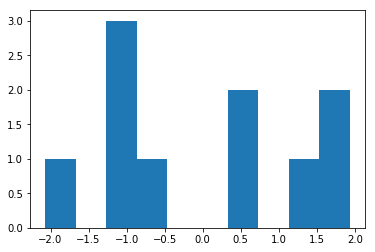

In [50]:
_ = plt.hist(neutral_velocity)

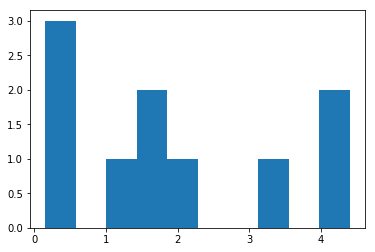

In [51]:
_ = plt.hist(differentiation_velocity)